In [30]:
!pip install yfinance nltk vaderSentiment requests xgboost optuna

In [70]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import requests
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import optuna
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Install required packages
import subprocess
subprocess.check_call(['pip', 'install', 'yfinance'])
subprocess.check_call(['pip', 'install', 'nltk'])
subprocess.check_call(['pip', 'install', 'vaderSentiment'])
subprocess.check_call(['pip', 'install', 'requests'])
subprocess.check_call(['pip', 'install', 'xgboost'])
subprocess.check_call(['pip', 'install', 'optuna'])


0

In [71]:
class DataCollector:
    def __init__(self, start_date: str, end_date: str, api_key: str):
        self.start_date = start_date
        self.end_date = end_date
        self.api_key = api_key

    def get_stock_data(self, ticker: str = "NVDA") -> pd.DataFrame:
        # Get 2 years of data before the start date to have sufficient history
        historical_start = (pd.to_datetime(self.start_date) - pd.DateOffset(years=2)).strftime('%Y-%m-%d')

        print(f"\nCollecting stock data from {historical_start} to {self.end_date}...")

        stock = yf.Ticker(ticker)
        data = stock.history(start=historical_start, end=self.end_date)

        if len(data) == 0:
            raise ValueError(f"No stock data available for {ticker} from {historical_start} to {self.end_date}")

        data.reset_index(inplace=True)
        data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
        return data

    def get_news_data(self, query: str = "Nvidia") -> pd.DataFrame:
        # Create synthetic sentiment data
        date_range = pd.date_range(start=self.start_date, end=self.end_date, freq='D')
        synthetic_news = pd.DataFrame({
            'date': date_range,
            'headline': 'Synthetic data point',
            'sentiment_score': np.random.normal(0, 0.2, len(date_range))  # Random sentiment with mean 0
        })
        return synthetic_news



In [72]:
class FeatureEngineering:
    @staticmethod
    def create_features(df: pd.DataFrame, lags: List[int]) -> pd.DataFrame:
        df = df.copy()

        # Fill NaN values in sentiment scores with 0
        df['sentiment_score'] = df['sentiment_score'].fillna(0)

        # Technical indicators
        df['MA5'] = df['Close'].rolling(window=5, min_periods=1).mean()
        df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
        df['RSI'] = FeatureEngineering.calculate_rsi(df['Close'])
        df['MACD'] = FeatureEngineering.calculate_macd(df['Close'])

        # Create price lags
        for lag in lags:
            df[f'price_lag_{lag}'] = df['Close'].shift(lag)
            df[f'volume_lag_{lag}'] = df['Volume'].shift(lag)

        # Create return features
        df['daily_return'] = df['Close'].pct_change()
        df['volatility'] = df['daily_return'].rolling(window=20, min_periods=1).std()

        # Forward fill technical indicators
        technical_columns = ['MA5', 'MA20', 'RSI', 'MACD', 'volatility']
        df[technical_columns] = df[technical_columns].fillna(method='ffill').fillna(method='bfill')

        # Fill any remaining NaN values
        df = df.fillna(method='ffill').fillna(method='bfill')

        return df

    @staticmethod
    def calculate_rsi(prices: pd.Series, periods: int = 14) -> pd.Series:
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods, min_periods=1).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)

    @staticmethod
    def calculate_macd(prices: pd.Series) -> pd.Series:
        exp1 = prices.ewm(span=12, adjust=False, min_periods=1).mean()
        exp2 = prices.ewm(span=26, adjust=False, min_periods=1).mean()
        macd = exp1 - exp2
        return macd.fillna(0)


In [73]:
class StockPredictor:
    def __init__(self, params: dict):
        self.model = xgb.XGBRegressor(**params)
        self.feature_columns = None

    def prepare_data(self, df: pd.DataFrame, target_col: str = 'Close',
                    forecast_horizon: int = 1) -> Tuple[pd.DataFrame, pd.Series]:
        df['target'] = df[target_col].shift(-forecast_horizon)
        df = df.dropna()

        self.feature_columns = [col for col in df.columns if col not in ['target', 'Date', 'date']]
        return df[self.feature_columns], df['target']

    def train(self, X: pd.DataFrame, y: pd.Series):
        self.model.fit(X, y)

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        return self.model.predict(X)

    def rolling_forecast(self, df: pd.DataFrame, window_size: int = 30) -> pd.DataFrame:
        predictions = []
        dates = []

        # Ensure we have enough data for the rolling window
        if len(df) < window_size + 1:
            raise ValueError(f"Insufficient data for rolling forecast. Need at least {window_size + 1} samples.")

        # Create predictions using rolling window
        for i in range(window_size, len(df)):
            train_data = df.iloc[i-window_size:i]
            X_train, y_train = self.prepare_data(train_data)
            self.train(X_train, y_train)

            test_features = df.iloc[i:i+1][self.feature_columns]
            pred = self.predict(test_features)

            predictions.append(pred[0])
            dates.append(df.iloc[i]['Date'])

        return pd.DataFrame({'Date': dates, 'Predicted_Close': predictions})



Analysis period: 2024-04-28 to 2024-05-28


Data collection summary:
Stock data range: 2022-04-28 00:00:00 to 2024-05-24 00:00:00
Number of stock data points: 522

Performing feature engineering...

Training model and making predictions...


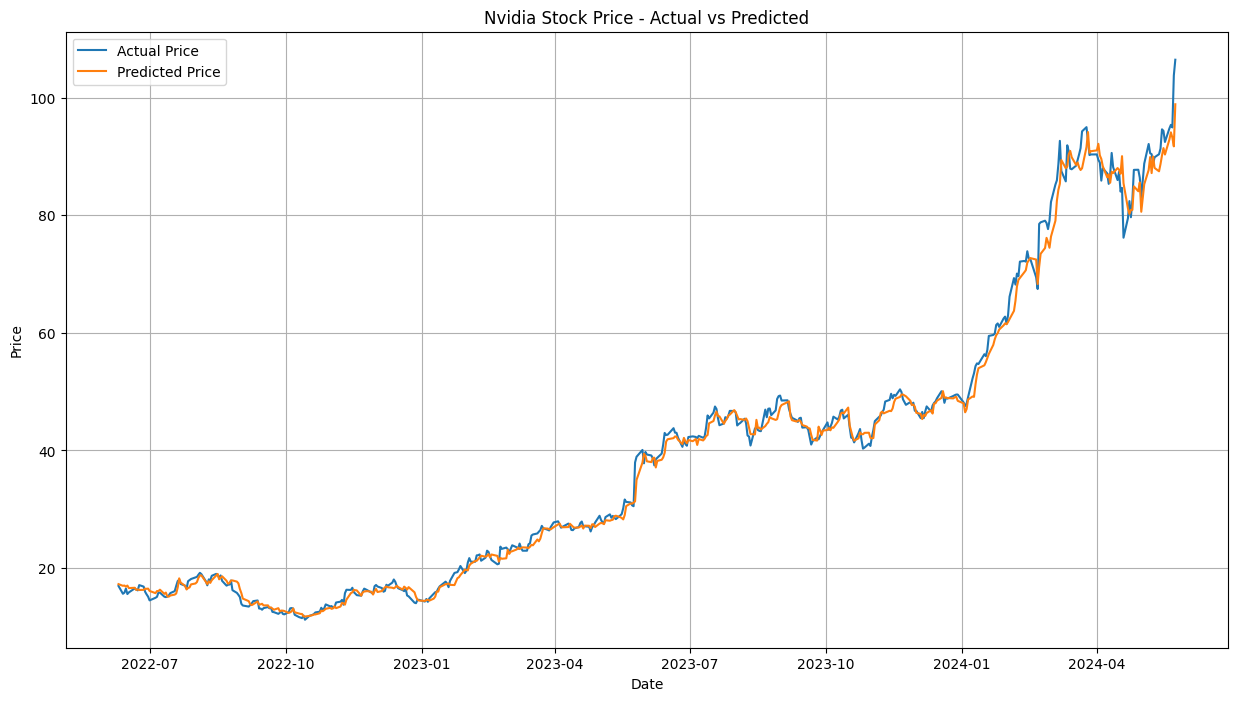


Model Performance Metrics:
RMSE: 1.75
MAE: 1.12
R2 Score: 0.99


In [74]:
def main():
    try:
        # Initialize parameters
        START_DATE = "2024-04-28"
        END_DATE = "2024-05-28"
        API_KEY = '7b468408067743b89eebad3e9018f624'
        LAGS = [1, 2, 3, 5, 7]  # Short-term lags only
        WINDOW_SIZE = 30  # Rolling window size for predictions

        print(f"\nAnalysis period: {START_DATE} to {END_DATE}")

        # Collect data
        collector = DataCollector(START_DATE, END_DATE, API_KEY)
        stock_data = collector.get_stock_data()
        news_data = collector.get_news_data()

        print(f"\nData collection summary:")
        print(f"Stock data range: {stock_data['Date'].min()} to {stock_data['Date'].max()}")
        print(f"Number of stock data points: {len(stock_data)}")

        # Merge data
        news_data['date'] = pd.to_datetime(news_data['date'])
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])

        aggregated_sentiment = news_data.groupby('date')['sentiment_score'].sum().reset_index()
        combined_data = pd.merge(stock_data, aggregated_sentiment, left_on='Date', right_on='date', how='left')

        # Feature engineering
        print("\nPerforming feature engineering...")
        feature_engineer = FeatureEngineering()
        processed_data = feature_engineer.create_features(combined_data, LAGS)

        # Prepare data for modeling
        X = processed_data.drop(['Date', 'date', 'target'], axis=1, errors='ignore')
        y = processed_data['Close']

        # Simple model parameters (skip optimization for speed)
        model_params = {
            'max_depth': 5,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'min_child_weight': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
        }

        # Train and predict
        print("\nTraining model and making predictions...")
        predictor = StockPredictor(model_params)
        predictions = predictor.rolling_forecast(processed_data, window_size=WINDOW_SIZE)

        if len(predictions) == 0:
            raise ValueError(f"No predictions generated. Check if window_size ({WINDOW_SIZE}) is appropriate for the data length ({len(processed_data)})")

        # Merge predictions with actual data
        comparison_df = pd.merge(
            processed_data[['Date', 'Close']],
            predictions,
            on='Date',
            how='inner'
        )

        # Visualize results
        plt.figure(figsize=(15, 8))
        plt.plot(comparison_df['Date'], comparison_df['Close'], label='Actual Price')
        plt.plot(comparison_df['Date'], comparison_df['Predicted_Close'], label='Predicted Price')
        plt.title('Nvidia Stock Price - Actual vs Predicted')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print performance metrics
        print("\nModel Performance Metrics:")
        rmse = np.sqrt(np.mean((comparison_df['Close'] - comparison_df['Predicted_Close']) ** 2))
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mean_absolute_error(comparison_df['Close'], comparison_df['Predicted_Close']):.2f}")
        print(f"R2 Score: {r2_score(comparison_df['Close'], comparison_df['Predicted_Close']):.2f}")

    except Exception as e:
        print(f"\nError: {str(e)}")
        print("\nPlease check the data collection and processing steps above.")
        raise

if __name__ == "__main__":
    main()